# 개와 고양이 이진 분류
---
- 로컬PC에 저장되어있는 이미지 데이터를 로딩해서 학습시키기
- GPU 사용
- [모델 작성 참고](https://github.com/raahatg21/Cats-and-Dogs-Dataset-with-Keras/blob/master/Cats_Dogs_9439.ipynb)

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### 1.데이터 준비

In [105]:
# !wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [106]:
# !unzip cats_and_dogs_filtered.zip

In [107]:
"""data_root = '/content/cats_and_dogs_filtered'
train_dir = '/content/cats_and_dogs_filtered/train'
val_dir = '/content/cats_and_dogs_filtered/validation'"""

data_root = './cats_and_dogs_filtered'
train_dir = './cats_and_dogs_filtered/train'
val_dir = './cats_and_dogs_filtered/validation'

In [108]:
import os

# 파일명 리스트 획득

train_cats_fname = os.listdir(os.path.join(train_dir, 'cats'))
train_dogs_fname = os.listdir(os.path.join(train_dir, 'dogs'))

test_cats_fname = os.listdir(os.path.join(val_dir, 'cats'))
test_dogs_fname = os.listdir(os.path.join(val_dir, 'dogs'))

print('train cats:', len(train_cats_fname))
print('train dogs:', len(train_dogs_fname))

print('test cats:', len(test_cats_fname))
print('test dogs:', len(test_dogs_fname))

train cats: 1000
train dogs: 1000
test cats: 500
test dogs: 500


- 레이블명

In [109]:
class_name = ['cat', 'dog']

In [110]:
import PIL

X_train = []
y_train = []

for i in range(len(train_cats_fname)):
    f = os.path.join(train_dir, 'cats', train_cats_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_train.append(arr)
    y_train.append(0)

for i in range(len(train_dogs_fname)):
    f = os.path.join(train_dir, 'dogs', train_dogs_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_train.append(arr)
    y_train.append(1)

In [111]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

(2000, 224, 224, 3) (2000,)


In [112]:
X_val = []
y_val = []

for i in range(len(test_cats_fname)):
    f = os.path.join(val_dir, 'cats', test_cats_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_val.append(arr)
    y_val.append(0)

for i in range(len(test_dogs_fname)):
    f = os.path.join(val_dir, 'dogs', test_dogs_fname[i])
    image = PIL.Image.open(f)
    image = image.resize((224, 224))
    arr = np.array(image)
    X_val.append(arr)
    y_val.append(1)

In [113]:
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape, y_val.shape)

(1000, 224, 224, 3) (1000,)


In [114]:
# data suffle
index = np.arange(0, len(X_train))
np.random.shuffle(index)
X_train = X_train[index]
y_train = y_train[index]

index = np.arange(0, len(X_val))
np.random.shuffle(index)
X_val = X_val[index]
y_val = y_val[index]

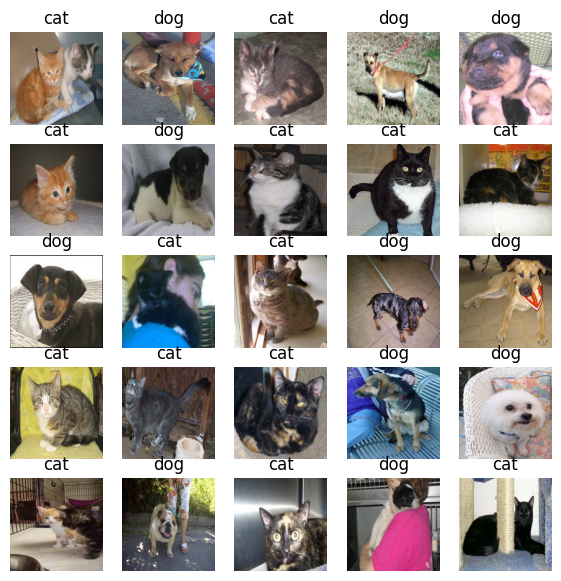

In [115]:
plt.figure(figsize=(7, 7))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(class_name[y_train[i]])
    plt.axis('off')

## Normalization

In [116]:
X_train_s = X_train / 255.
X_val_s = X_val / 255.

print(np.max(X_train_s), np.min(X_train_s))

1.0 0.0


### One Hot Encoding

In [117]:
from keras.utils import to_categorical

y_train_o = to_categorical(y_train)
y_val_o = to_categorical(y_val)

y_train_o[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

### Model

In [118]:
X_train_s.shape, y_train_o.shape

((2000, 224, 224, 3), (2000, 2))

In [119]:
from keras import layers

model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [120]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 128)     

In [121]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [122]:
EPOCHS = 10
BATCH_SIZE = 32

histroy = model.fit(
    X_train_s, y_train_o,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_s, y_val_o),
    verbose=1
)

Epoch 1/10
63/63 [==============================] - 5s 70ms/step - loss: 0.7278 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6933 - accuracy: 0.4790 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6935 - accuracy: 0.4845 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6927 - val_accuracy: 0.4980
Epoch 5/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6918 - accuracy: 0.5255 - val_loss: 0.6914 - val_accuracy: 0.5260
Epoch 6/10
63/63 [==============================] - 4s 62ms/step - loss: 0.6787 - accuracy: 0.5855 - val_loss: 0.6809 - val_accuracy: 0.5790
Epoch 7/10
63/63 [==============================] - 4s 61ms/step - loss: 0.6551 - accuracy: 0.6135 - val_loss: 0.6575 - val_accuracy: 0.6240
Epoch 8/10
63

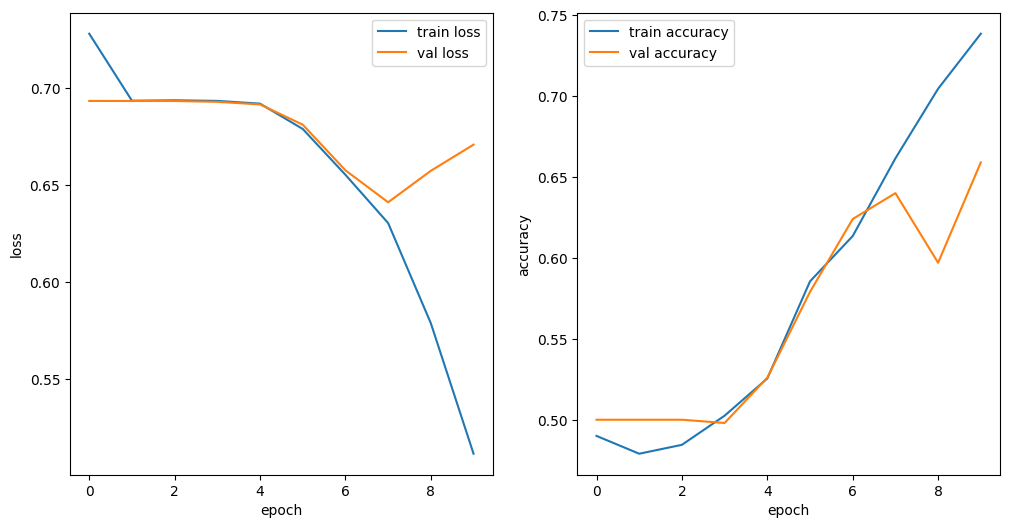

In [123]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'], label='train loss')
    plt.plot(hist['epoch'], hist['val_loss'], label='val loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'], label='train accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.show()

plot_history(histroy)